# Chapter 3: Splitting datasets one feature at a time: decision tree

The decision tree is one of the most commonly used classification techniques. 

It has `decision blocks` (rectangles) and `terminating blocks` (ovals) where some conclusion has been reached, as shown in the following example. The right and left arrows coming out of the decision blocks are known as `branches`, and they can lead to other `decision blocks` or to a `terminating block`.

The *kNN* algorithm did a great job of classifying, but it didn’t lead to any major insights about the data. One of the best things about decision trees is that **humans can easily understand the data**. 
 
The algorithm we’ll build in this chapter will be able to take a set of data, build a decision tree, and draw a tree like the one in the following example. The decision tree does a great job of distilling data into knowledge. With this, we can take a set of unfamiliar data and extract a set of rules. 

The machine learning will take place as the machine creates these rules from the dataset. Decision trees are often used in **expert systems**, and the results obtained by using them are often comparable to those from a human expert with decades of experience in a given field. 

In [11]:
# check directory
# import os
# os.listdir()

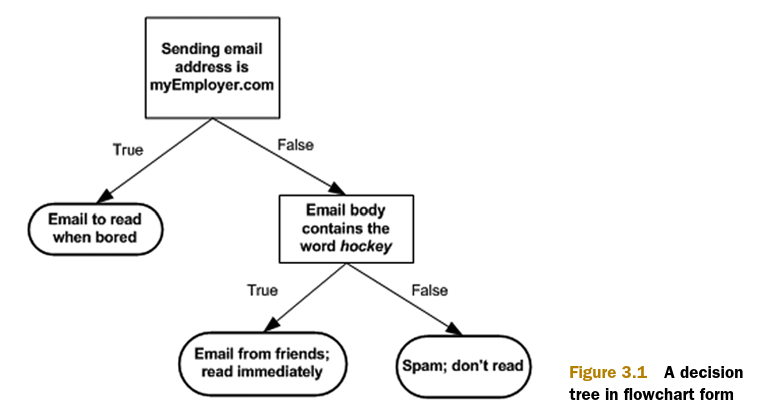

In [48]:
from IPython.display import Image
Image('Machine_Learning_In_Action/Decision_Tree_Example.png')

# Image from: Harrington, P. (2012). Machine Learning In Action. Manning Publications.

In the first section, we’ll discuss methods used to construct trees and start writing code to construct a tree.

Next, we’ll address some metrics that we can use to measure the algorithm’s success.

Finally, we’ll use recursion to build our classifier and plot it using `Matplotlib`. 

When we have the classifier working, we’ll take some data of a contact lens prescription and use our classifier to try to predict what lenses people will need.

### 3.1 Tree construction

Decision trees
* Pros: Computationally cheap to use, easy for humans to understand learned results, missing values OK, can deal with irrelevant features
* Cons: Prone to overfitting
* Works with: Numeric values, nominal value

the decision tree–building algorithm:
* We’ll first discuss the mathematics that decide how to split a dataset using something called `information theory`
* We’ll then write some code to apply this theory to our dataset
* Finally we’ll write some code to build a tree

Steps to build a tree:
* Step 1:  try every feature and measure which split will give out the best results
* Step 2: choose a feature to use to split the data
* Step 3: split the dataset into subsets using the feature. 
* Step 4: repeat the above process until all data is classified (If the data on the branches is the same class, then we've properly classified it and don’t need to continue splitting it. If the data isn’t the same, then we need to repeat the splitting process on this subset.)

**Pseudo-code** for a function called `createBranch()` would look like this:

First, check if every item in the dataset is in the same class;

*If so* --> return the class label; *Else* --> find the best feature to split the data.

After splitting the dataset, create a branch node. At the node, for each split, call `createBranch` and add the result to the branch node. 

Then return branch node.

Please note the **recursive** nature of `createBranch()`.

**General approach** to decision trees
 1. Collect: Any method.
 2. Prepare: This tree-building algorithm works only on nominal values, so any continuous values will need to be quantized.
 3. Analyze: Any method. You should **visually** inspect the tree after it is built.
 4. Train: Construct a tree data structure. 
 5. Test: Calculate the **error rate** with the learned tree.
 6. Use: This can be used in any supervised learning task. Often, trees are used to better understand the data.
 
**Note**:
We’ll follow the *ID3 algorithm*, which tells us how to split the data and when to stop splitting it. (See http://en.wikipedia.org/wiki/ID3_algorithm for more information.) 

We’re also going to split on one and only one feature at a time. 

Now let's see how to choose which one to use first. 

### 3.1.1 Information gain

We choose to split our dataset in a way that makes our unorganized data more organized. There are multiple ways to do this, and each has its own advantages and disadvantages. One way to organize this messiness is to **measure the information**.

Using information theory, we can measure the information before and after the split. 

Information theory is a branch of science that’s concerned with quantifying information. 

The change in information before and after the split is known as the **information gain**. After knowing how to calculate the information gain, we can split the data across every feature to see which split gives us the highest information gain. The split with the highest information gain is our best option. 

Before we can measure the best split and start splitting our data, we need to know how to calculate the information gain. 

The measure of information of a set is known as the **Shannon entropy**, or just **entropy** for short. Its name comes from the father of information theory, Claude Shannon.
 
**Entropy** is defined as the expected value of the information. First, we need to define information. 

If we’re classifying something that can take on multiple values, the information for symbol $x_{i}$ is defined as

$I(x_{i}) = \log_{2} p(x_{i})$

where $p(x_{i})$ is the probability of choosing this class.

To calculate entropy, we need the expected value of all the information of all possible values of our class. This is given by 

$H = - \sum \limits_{i = 1}^{n} p(x_{i}) \log_{2} p(x_{i})$

where $n$ is the number of classes. 

In [1]:
# define a function to calculate the Shannon entropy of a dataset
from math import log

def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    # create a dictionary whose keys are the labels in the dataset
    labelCounts = {}
    for featVec in dataSet:                        
        currentLabel = featVec[-1]                      
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0              
        labelCounts[currentLabel] += 1             
    # calculate the Shannon entropy
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob,2)             
    return shannonEnt

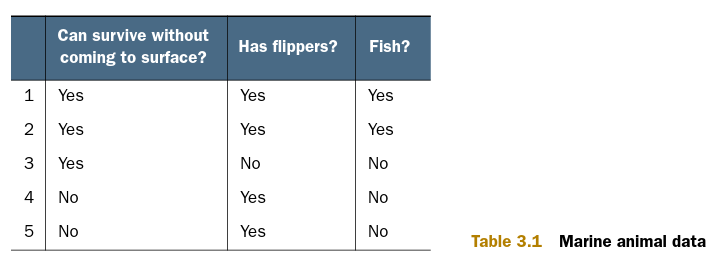

In [14]:
# create a dataset that matches the following table
Image('Machine_Learning_In_Action/Marine_animal_data.png')

In [2]:
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    return dataSet, labels

In [16]:
myDat, labels = createDataSet()

In [17]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [18]:
labels

['no surfacing', 'flippers']

In [19]:
# calculate the Shannon entropy
calcShannonEnt(myDat)

0.9709505944546686

The higher the entropy, the more *mixed up* the data is. 

Let’s make the data a little messier and see how the entropy changes. 

We’ll add a third class, which is called `maybe`, and see how the entropy changes: 

In [20]:
myDat[0][-1] = 'maybe'

In [21]:
myDat

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [22]:
calcShannonEnt(myDat)

1.3709505944546687

Let’s split the dataset in a way that will give us the largest information gain. We won’t know how to do that unless we actually split the dataset and measure the information gain.

Another common measure of disorder in a set is the **Gini impurity**, which is the probability of choosing an item from the set and the probability of that item being misclassified. 

We won’t get into the Gini impurity. Instead, we’ll move on to splitting the dataset and building the tree. 

### 3.1.2 Splitting the dataset

For our classifier algorithm to work, we need to measure the entropy, split the dataset, measure the entropy on the split sets, and see if splitting it was the right thing to do. We’ll do this for all of our features to determine the best feature to split on.

In [3]:
# create a function to split the dataset
def splitDataSet(dataSet, axis, value): 
    """
    dataset: the dataset we’ll split; 
    axis: the feature we’ll split on; 
    value: the value of the feature to return
    """
    retDataSet = []                          
    for featVec in dataSet: # for each record in the dataset
        if featVec[axis] == value: # if its feature/ axis fits the value 
            reducedFeatVec = featVec[:axis]        
            reducedFeatVec.extend(featVec[axis+1:]) # by doing this, reducedFeatVec will be the reduced version of featVec 
            retDataSet.append(reducedFeatVec)   # the reduced version gets appended to the result   
    return retDataSet

# So basically the function split the dataset using some feature and some given value

In [24]:
# difference between append() and extend()
a = [1, 2, 3]
b = [4, 5, 6]

a.extend(b)

In [25]:
a

[1, 2, 3, 4, 5, 6]

In [26]:
a = [1, 2, 3]
b = [4, 5, 6]

a.append(b)

a

[1, 2, 3, [4, 5, 6]]

In [4]:
# try one example
myDat,labels = createDataSet()

In [5]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [6]:
splitDataSet(myDat, 0, 1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [7]:
splitDataSet(myDat, 0, 0)

[[1, 'no'], [1, 'no']]

In [8]:
# take a detailed look at the splitting
myDat[0]

[1, 1, 'yes']

In [33]:
myDat[0][0]

1

In [35]:
res = myDat[0][:0]
res

[]

In [36]:
myDat[0][1:]

[1, 'yes']

In [37]:
res.extend(myDat[0][1:])
res

[1, 'yes']

In [39]:
# note that list[:axis] and list[axis + 1:] is not continuous
listExample = [0, 1, 2, 3, 4, 5, 6]
print(listExample[:2])
print(listExample[3:])

[0, 1]
[3, 4, 5, 6]


Now let's combine the Shannon entropy calculation and the `splitDataSet()` function to cycle through the dataset and decide which feature is the best to split on. 

Using the entropy calculation tells us which split best organizes the data. 

In [9]:
def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1    # given the last one is the value  
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):        
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)                        
        newEntropy = 0.0
        for value in uniqueVals:                            
            subDataSet = splitDataSet(dataSet, i, value)      
            prob = len(subDataSet)/float(len(dataSet))      
            newEntropy += prob * calcShannonEnt(subDataSet) 
        infoGain = baseEntropy - newEntropy      # calculate the reduction in entropy           
        if (infoGain > bestInfoGain): # remember we want the biggest information gain, aka the most reduction in entropy
            bestInfoGain = infoGain          
            bestFeature = i                    
    return bestFeature 

We’ve made a few **assumptions** about the data. 

The first assumption is that it comes in the form of a list of lists, and all these lists are of equal size. 

The next assumption is that the last column in the data or the last item in each instance is the class label of that instance. 

We didn’t make any assumption on the type of data in the lists. It could be a number or a string; it doesn’t matter.

*Some explanation about `chooseBestFeatureToSplit()`:* 

Sets are like lists, but a value can occur only once. Creating a new set from a list is one of the fastest ways of getting the unique values out of list in Python.

For each feature, the new entropy is calculated and summed up for all the unique values of that feature. 

The information gain is the reduction in **entropy** or the reduction in **messiness**. We can also say entropy as the reduction of disorder.

In [11]:
myDat, labels = createDataSet()

In [12]:
chooseBestFeatureToSplit(myDat)
# The code tells us that the 0th feature was the best feature to split on.

0

In [13]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [14]:
# we can verify this by calculating the Shannon entropy correspondingly

# firstly: split the dataset using the 0th feature
data0Split1 = splitDataSet(myDat, 0, 1)
data0Split0 = splitDataSet(myDat, 0, 0)

# secondly: calculate its Shannon entropy
ent1 = calcShannonEnt(data0Split1)
ent0 = calcShannonEnt(data0Split0)

# thirdly: calculate the new entropy
prob1 = len(data0Split1)/float(len(myDat))
prob0 = len(data0Split0)/float(len(myDat))
newEnt0 = prob1 * ent1 + prob0 * ent0
newEnt0

0.5509775004326937

In [15]:
# repeat the process for the second feature

# firstly: split the dataset using the 0th feature
data1Split1 = splitDataSet(myDat, 1, 1)
data1Split0 = splitDataSet(myDat, 1, 0)

# secondly: calculate its Shannon entropy
ent11 = calcShannonEnt(data1Split1)
ent10 = calcShannonEnt(data1Split0)

# thirdly: calculate the new entropy
prob11 = len(data1Split1)/float(len(myDat))
prob10 = len(data1Split0)/float(len(myDat))
newEnt1 = prob11 * ent11 + prob10 * ent10
newEnt1

0.8

Now that we can measure how organized a dataset is and we can split the data, it’s time to put all of this together and build the decision tree.

### 3.1.2 Rercursively building the tree

We now have all the components needed to create an algorithm that makes decision trees from a dataset. 

It works like this: 
* we start with our dataset and split it based on the best attribute to split. These aren’t binary trees, so we can handle more than two-way splits. 

* Once split, the data will traverse down the branches of the tree to another node. This node will then split the data again. We’re going to use the principle of recursion to handle this. 

* We’ll stop under the following conditions: running out of attributes on which to split, or all the instances in a branch are the same class. If all instances have the same class, then we’ll create a leaf node, or terminating block. Any data that reaches this leaf node is deemed to belong to the class of that leaf node. 

* The first stopping condition makes this algorithm tractable, and we can even set a bound on the maximum number of splits we can have. 

We’ll encounter other decision-tree algorithms later, such as **C4.5** and **CART**. These do not “consume” the
 features at each split. This creates a problem for these algorithms because they split the data, but the number of features doesn’t decrease at each split. Don’t worry about that for now. 
 
We can simply count the number of columns in our dataset to see if we’ve run out of attributes. If our dataset has run out of attributes but the class labels are not all the same, we’ll take a majority vote to decide what to call on the leaf node. 

In [32]:
import operator

def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): 
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

This function takes a list of class names and then creates a dictionary whose keys are the unique values in classList, and the object of the dictionary is the frequency of occurrence of each class label from classList. 

Finally, we use the operator to sort the dictionary by the keys and return the class that occurs with the greatest frequency.

In [24]:
# try to understand the majorityCnt() function

classList = ['yes', 'yes', 'yes', 'no', 'no']

classCount={}
for vote in classList:
    if vote not in classCount.keys(): 
        classCount[vote] = 0
    classCount[vote] += 1

In [25]:
classCount

{'yes': 3, 'no': 2}

In [27]:
classCount.items()

dict_items([('yes', 3), ('no', 2)])

In [28]:
sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)

[('yes', 3), ('no', 2)]

In [30]:
sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)

In [31]:
sortedClassCount[0][0]

'yes'

In [34]:
# Now let's build a tree

def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]      # if there's only one class, return the class                         
    if len(dataSet[0]) == 1:                       
        return majorityCnt(classList)   # if there's no features, return the majority of the class
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])                                  
    featValues = [example[bestFeat] for example in dataSet]   
    uniqueVals = set(featValues)                           
    for value in uniqueVals:
        subLabels = labels[:] 
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree

The function `createTree` takes two inputs: the dataset and a list of labels. 

The list of labels contains a label for each of the features in the dataset. The algorithm could function without this, but it would be difficult to make any sense of the data. All of the previous assumptions about the dataset still hold. 

We’ll use the Python dictionary to store the tree. The `myTree` dictionary will be used to store the tree, and we’ll see how that works soon. 

We get all the unique values from the dataset for our chosen feature: bestFeat. Finally, we iterate over all the unique values from our chosen feature and recursively call `createTree()` for each split of the dataset. This value is inserted into our `myTree` dictionary, so we end up with a lot of **nested dictionaries** representing our tree. 

Before we get into the nesting, note that the *subLabels = labels[:]* line makes a copy of labels and places it in a new list called `subLabels`. We do this because Python passes lists by reference and we’d like the original list to be the same every time we call `createTree()`. 

In [41]:
myDat,labels = createDataSet()

In [42]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [43]:
labels

['no surfacing', 'flippers']

In [44]:
myTree = createTree(myDat,labels)

In [45]:
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [46]:
labels # it has been changed

['flippers']

The variable `myTree` contains the nested dictionaries, which we’re using to represent our tree structure. 

Reading left to right, the first key, *'no surfacing'*, is the name of the first feature that was split by the create tree. The value of this key is another dictionary. 

This second dictionary’s keys are the splits of the 'no surfacing' feature. The values of these keys are the children of the 'no surfacing' node. The values are either a class label or another dictionary. 

If the value is a class label, then that child is a **leaf node**. If the value is another dictionary, then that child node is a **decision node** and the format repeats itself. In our example, we have three leaf nodes and two decision nodes. 

Now that we’ve properly constructed the tree, we need to display it so that humans can properly understand the information.

## 3.2 Plotting trees in Python with Matplotlib annotations

The tree we made in the previous section is great, but it’s a little difficult to visualize. 

In this section, we’ll use Matplotlib to create a tree to look at. 

One of the greatest strengths of decision trees is that humans can easily understand them. The plotting library we used in the previous chapter is extremely powerful. Unfortunately, Python doesn’t include a good tool for plotting trees, so we’ll make our own. 

We’ll write a program to draw a decision tree like the one shown below. 

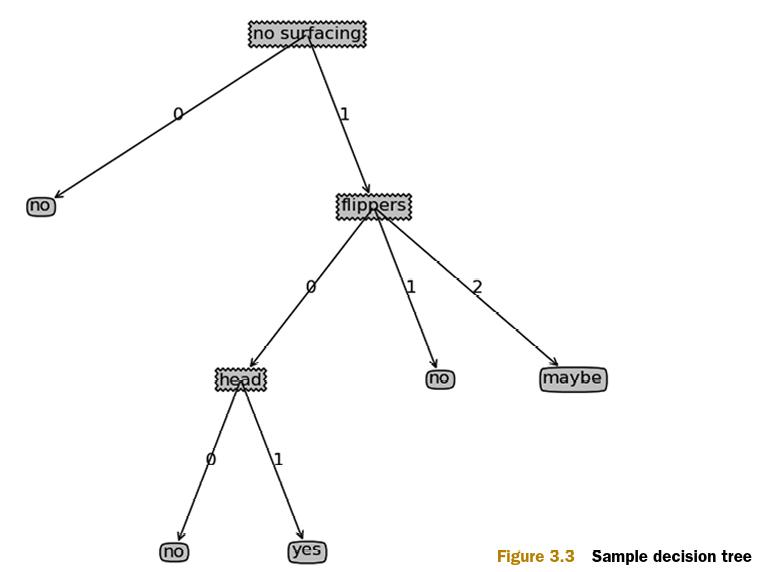

In [49]:
# create a dataset that matches the following table
Image('Machine_Learning_In_Action/Simple_decision_tree.png')